## Objective : Whether any relationship between the Predictors (age and ingredients) and the response variable (compressive strength) exists?

**Given there is a relationship**
*How strong is it?
*Which predictors contribute to compressive strength?
*How large is the effect of each predictor on compressive strength?
*How accurately can I predict compressive strength?
*Is the relationship linear?
*Is there synergy/interaction among the predictors?

#### 1. Import packages and Data

In [1]:
#import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#supress warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
#import data
concrete_data = pd.read_csv('Concrete_Data_Yeh.csv')

#### 2. Initial EDA and Distributions

In [4]:
#look at formatting of entries
concrete_data.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [6]:
#look at null count and dtype
concrete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [7]:
#look at distribution of data
concrete_data.describe()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


#### 3. Plotting distribution

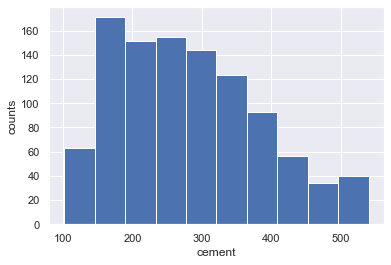

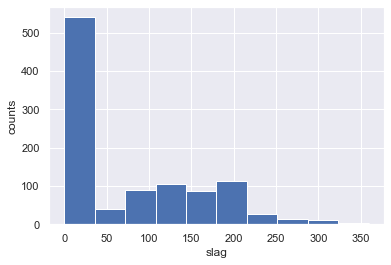

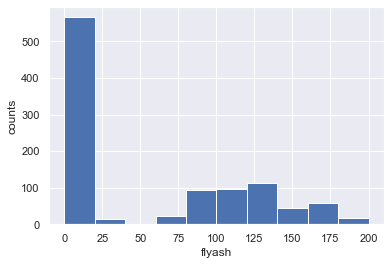

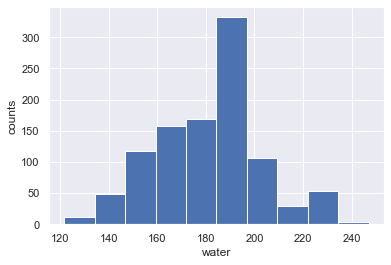

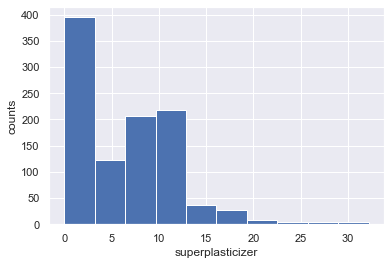

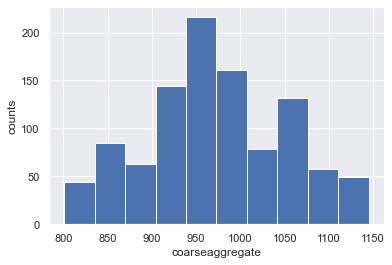

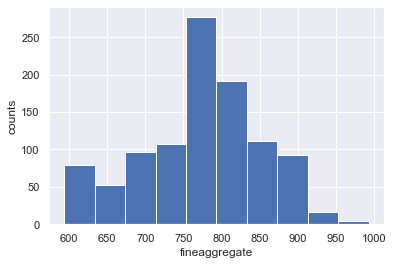

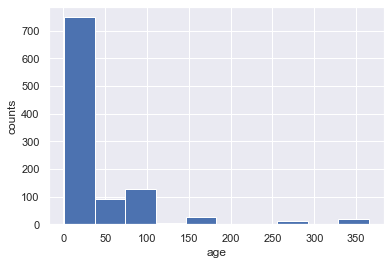

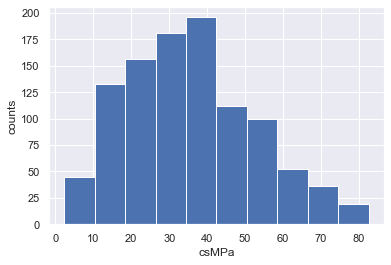

In [8]:
#look at data distribution
for i in concrete_data.columns:
    plt.hist(concrete_data[i])
    plt.xticks()
    plt.xlabel(i)
    plt.ylabel('counts')
    plt.show()

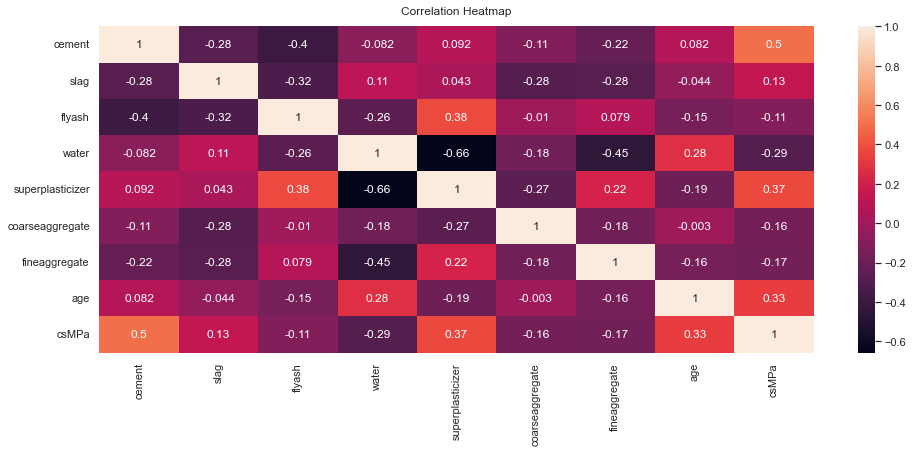

In [9]:
#heat map using Pearson's coefficient
plt.figure(figsize=(16, 6))
sns.heatmap(concrete_data.corr(), annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [10]:
#create bins from compressive strength
bins = pd.qcut(concrete_data['csMPa'], q=4)

#add bins to concrete df
concrete_data['bins']=bins

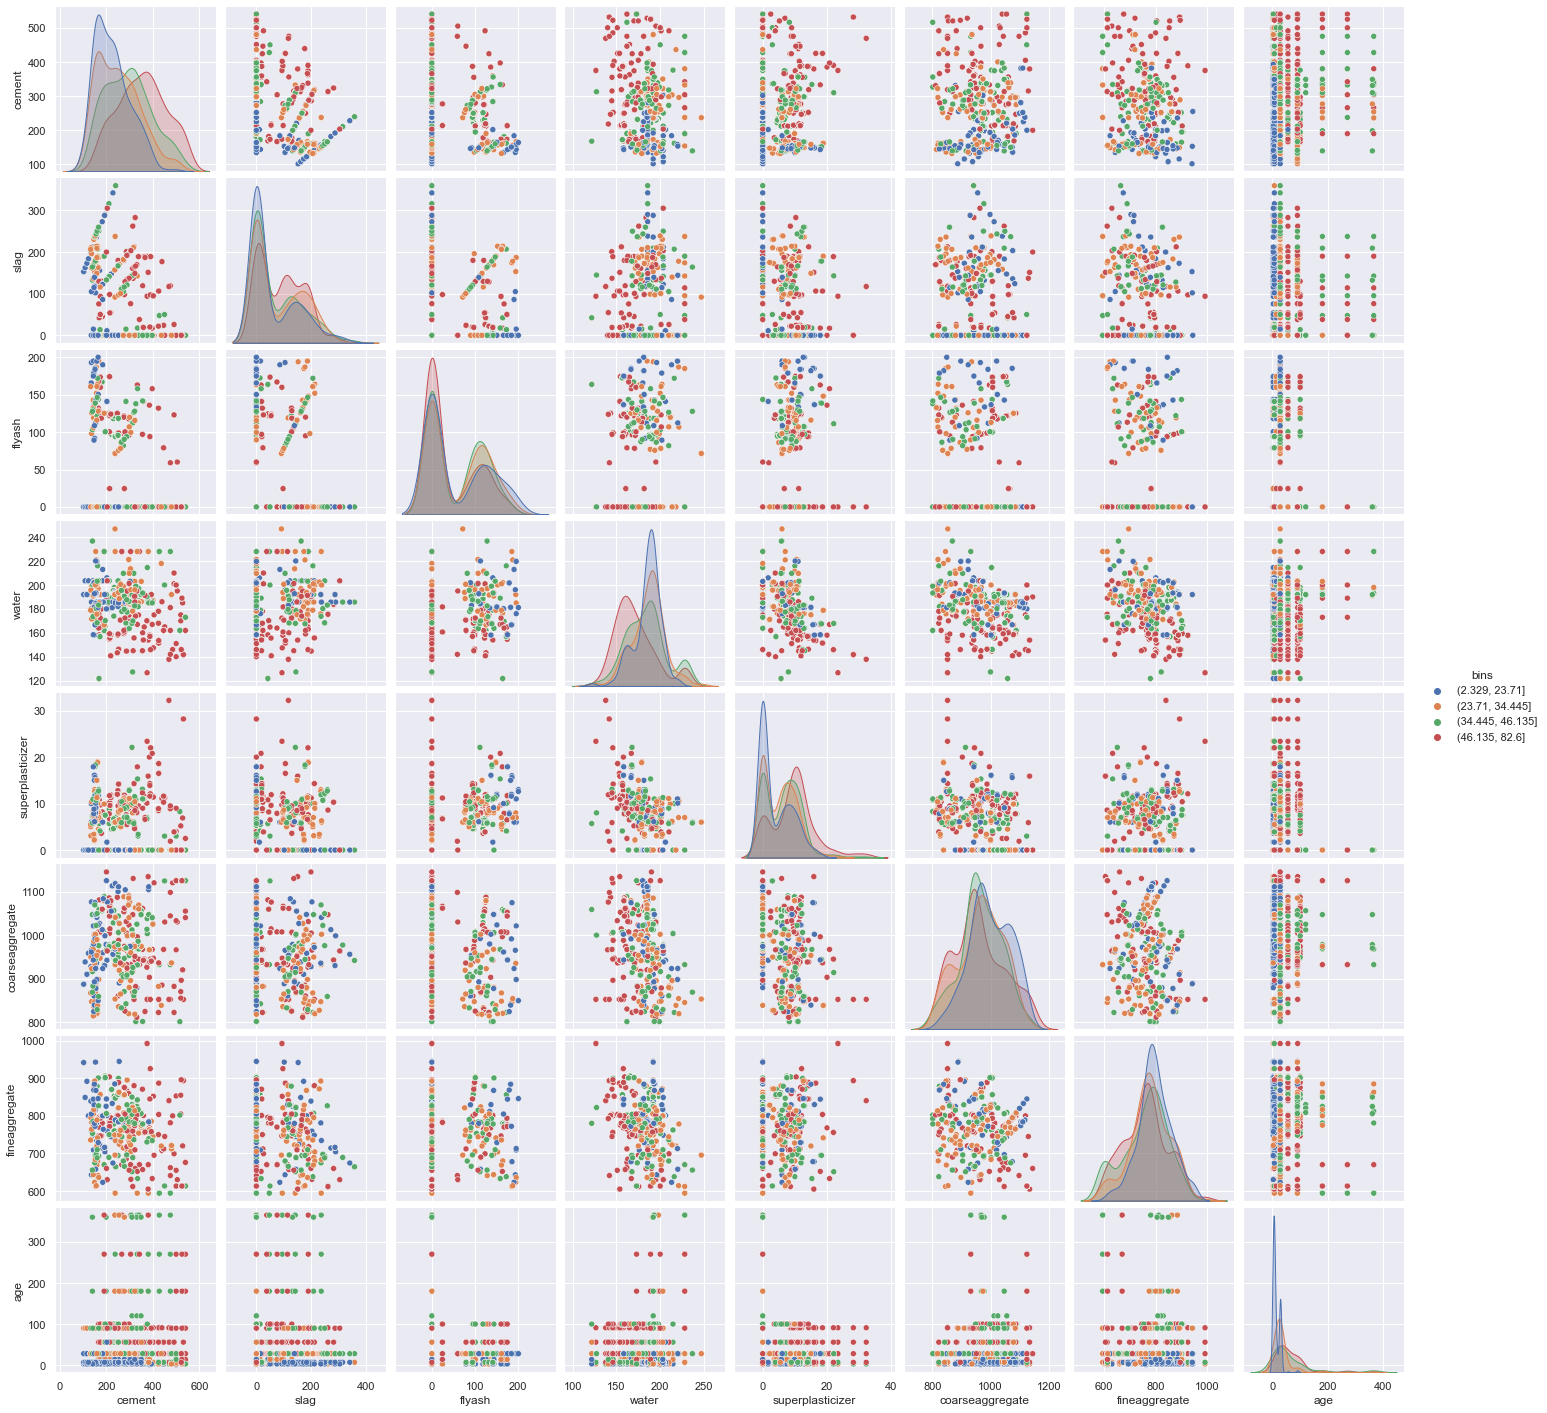

In [12]:
#look at how target is distributed among variables
sns.pairplot(concrete_data.loc[:, (concrete_data.columns != 'csMPa')], hue='bins')
plt.show()

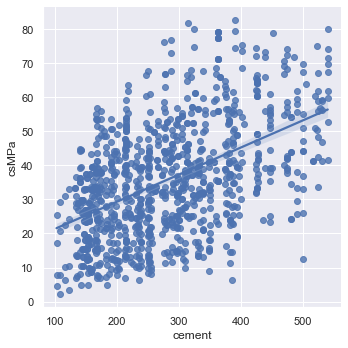

In [13]:
#plot strongest linear correlation
sns.lmplot(x='cement', y='csMPa',data=concrete_data)
plt.show()

In [14]:
#drop bins from concrete data
concrete_data = concrete_data.drop('bins', axis=1)

In [15]:
#copy of variables and target
X = concrete_data.copy()
y = X.pop('csMPa')

#### 4. Mutual Information

In [16]:
#make a copy of features matrix for mutual information analysis
X_mi = X.copy()

#label encoding for categorical variables
for colname in X_mi.select_dtypes("object"):
    X_mi[colname], _ = X_mi[colname].factorize()

#all discrete features have int dtypes
discrete_features = X_mi.dtypes == object

In [17]:
#some continuous variables also have int dtypes
discrete_features[X_mi.columns] = False

In [18]:
#use regression since the target variable is continuous
from sklearn.feature_selection import mutual_info_regression

#define a function to produce mutual information scores
def make_mi_scores(X_mi, y, discrete_features):
    mi_scores = mutual_info_regression(X_mi, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#compute mutual information scores
mi_scores = make_mi_scores(X_mi, y, discrete_features)
mi_scores

age                 0.361140
water               0.353240
cement              0.304136
coarseaggregate     0.254613
fineaggregate       0.215406
superplasticizer    0.210836
slag                0.178532
flyash              0.124742
Name: MI Scores, dtype: float64

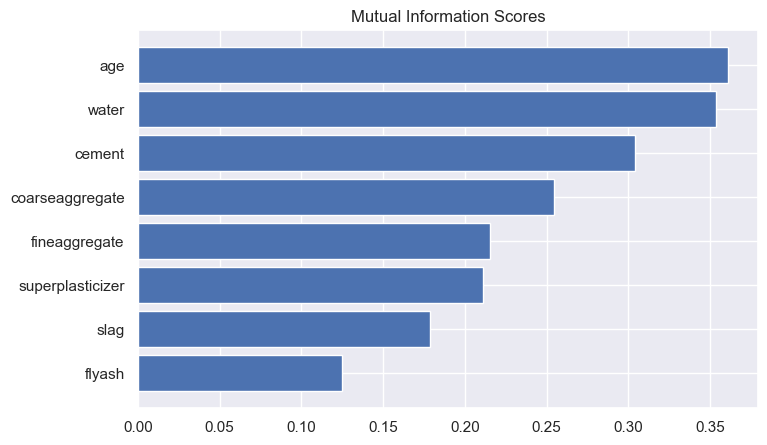

In [19]:
#define a function to plot mutual information scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

#plot the scores
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

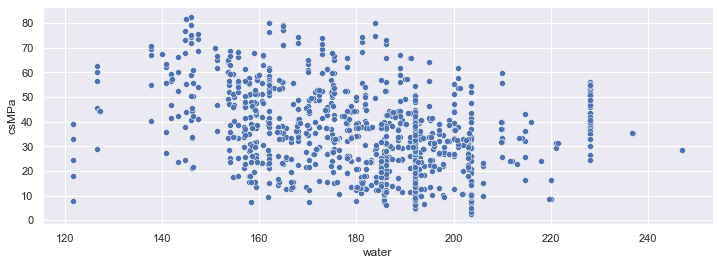

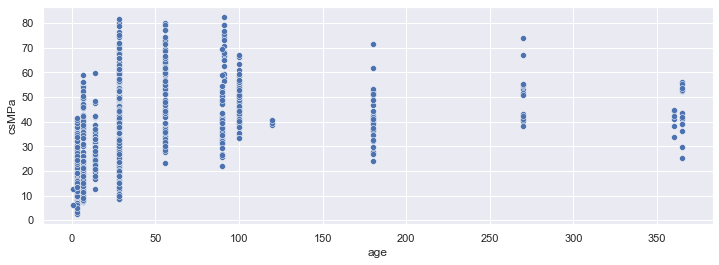

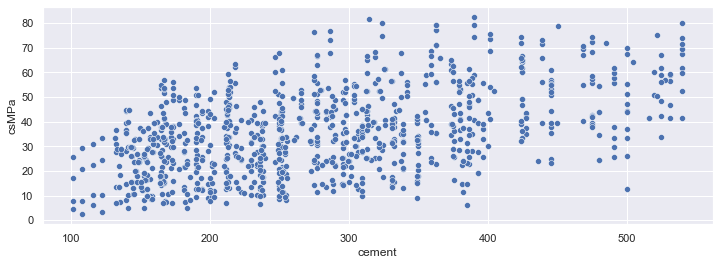

In [20]:
#plot top MI score predictors against target
for i in ['water', 'age', 'cement']:
    fig, ax = plt.subplots(figsize=(12,4))
    sns.scatterplot(x=X_mi[i], y=y, ax=ax)
    plt.show()